In [0]:
from pyspark.sql.functions import col, lit, sum, count, year, month, dayofmonth, desc, last_day, to_timestamp, to_date, unix_timestamp
from pyspark.sql.types import *
from datetime import datetime, timedelta
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

REF_DATE = datetime.strptime('04/11/2020', '%d/%m/%Y')

In [0]:
Ref_Geo = spark.read.format("delta").load("/mnt/kbi/KBI_NG/PROD/tmp/Ref_Geo")

In [0]:
Curr_Year = datetime.now().year

schema = StructType([
        StructField('CAI_MARKET_FDM_SK', StringType(), False),
        StructField('DT_INVOICE', TimestampType(), False),
        StructField('DT_BORD_REF', TimestampType(), False),
        StructField('COMPANY_CODE', StringType(), False),
        StructField('COUNTRY_CODE', StringType(), False),
        StructField('CUSTOMER_CODE', StringType(), False),
        StructField('CAI_CODE', StringType(), False),
        StructField('PRODUCT_LINE_CODE', StringType(), False),
        StructField('QUANTITY', DoubleType(), False),
        StructField('CA_BF_EUROS', DoubleType(), False),
        StructField('CA_BF_CUR', DoubleType(), False),
        StructField('INVOICE_CURRENCY', StringType(), False),
        StructField('MT_HT_EUROS', DoubleType(), False),
        StructField('MT_HT_CUR', DoubleType(), False),
        StructField('BRAND_CODE', StringType(), False),
        StructField('MARKET_CODE', StringType(), False),
        StructField('DT_UPDATE', StringType(), False),
        StructField('FILE_AUDIT_ID', StringType(), False),
        StructField('FILE_ID', StringType(), False),
        StructField('DT_YEARMONTH', StringType(), False),
        StructField('TONNAGE', DoubleType(), False),
        StructField('MFS_IDR', StringType(), False),
        StructField('ORIGINAL_COMPANY_C', StringType(), False),
        StructField('OFF_RCHP_C', StringType(), False),
        StructField('SOURCE_C', StringType(), False),
        StructField('CUST_FDM_SK', StringType(), False),
        StructField('DT_BORDEREAU', StringType(), False)
        ])

#load last 5 years
# path = ["/mnt/adls/30_datamart_D2/KBI/Daily_Sales/FULL/FDM_DAILY_SALES_WW_F-"+str(Curr_Year)+"*.csv", 
#          "/mnt/adls/30_datamart_D2/KBI/Daily_Sales/FULL/FDM_DAILY_SALES_WW_F-"+str(Curr_Year-1)+"*.csv",
#          "/mnt/adls/30_datamart_D2/KBI/Daily_Sales/FULL/FDM_DAILY_SALES_WW_F-"+str(Curr_Year-2)+"*.csv",
#          "/mnt/adls/30_datamart_D2/KBI/Daily_Sales/FULL/FDM_DAILY_SALES_WW_F-"+str(Curr_Year-3)+"*.csv",
#          "/mnt/adls/30_datamart_D2/KBI/Daily_Sales/FULL/FDM_DAILY_SALES_WW_F-"+str(Curr_Year-4)+"*.csv"]

path = ["/mnt/adls/30_datamart_D2/KBI/Daily_Sales/FULL/FDM_DAILY_SALES_WW_F-202011.csv"]

Daily_Sales = (spark.read
               .option('header', 'true')
               .option('sep', ";")
               .schema(schema)
               .csv(path)
               .select("DT_BORD_REF", "CAI_MARKET_FDM_SK", "COMPANY_CODE", "COUNTRY_CODE", "CUSTOMER_CODE", "QUANTITY")
               .groupby("DT_BORD_REF", "CAI_MARKET_FDM_SK", "COMPANY_CODE", "COUNTRY_CODE", "CUSTOMER_CODE").agg(sum('QUANTITY').alias('QUANTITY'))
               .join(Ref_Geo, on='COUNTRY_CODE', how='left')
               .drop('COUNTRY_CODE')
               .cache())

#display(Daily_Sales)

In [0]:
W_days = (spark.read
          .format("delta")
          .load("/mnt/adls/20_datastore/FDM/CMN/Time/fdm_date_working_day_cmn_dim/")
          .select(col("country_code").alias("COUNTRY_CODE"), "dt_fulldate", "working_day_number_month", "working_day_flag", "week", "working_day_per_month")
          .join(Ref_Geo, on='COUNTRY_CODE', how='left')
          .drop('COUNTRY_CODE'))

W_days_mod = W_days\
  .select(col("dt_fulldate").alias("DT_BORD_REF"), "COUNTRY_ALPHA", "working_day_flag")\
  .filter(month("DT_BORD_REF") == REF_DATE.month)\
  .filter(year("DT_BORD_REF") == REF_DATE.year)\
  .withColumn('REF_DATE',lit(REF_DATE))\
  .withColumn(
      'MTD_WD',
      F.count(
          F.when(F.col('working_day_flag') == 'Y', 1)
      ).over(
          Window.partitionBy('country_alpha', F.month('dt_bord_ref'))
                .orderBy('dt_bord_ref')
      )
  ).withColumn(
      'MTG_WD',
      F.count(
          F.when(F.col('working_day_flag') == 'Y', 1)
      ).over(
          Window.partitionBy('country_alpha', F.month('dt_bord_ref'))
                .orderBy('dt_bord_ref')
                .rowsBetween(1, Window.unboundedFollowing)
      )
  )

In [0]:
d0 = datetime(year=REF_DATE.year, month=REF_DATE.month, day=1)
d1 = datetime(year=REF_DATE.year, month=REF_DATE.month+1, day=1)

calendar=[]
for i in range (1, int(str(d1-d0)[:2])+1):
  calendar.append("{:02d}".format(i)+"/"+"{:02d}".format(REF_DATE.month)+"/"+"{:04d}".format(REF_DATE.year))


MTD = Daily_Sales\
  .filter(month("DT_BORD_REF") == REF_DATE.month)\
  .filter(year("DT_BORD_REF") == REF_DATE.year)\
  .filter(dayofmonth("DT_BORD_REF") < REF_DATE.day)\
  .join(W_days_mod, on=['DT_BORD_REF','COUNTRY_ALPHA'], how='left')\
  .sort(col("DT_BORD_REF").desc())\
  .select("DT_BORD_REF","CAI_MARKET_FDM_SK","COMPANY_CODE","CUSTOMER_CODE","COUNTRY_ALPHA", "MTD_WD", "MTG_WD", "working_day_flag", "QUANTITY")


MTG_dates = spark.createDataFrame(calendar, StringType())\
.withColumn("value", to_timestamp("value", "dd/MM/yyyy"))\
.filter(col("value") >= REF_DATE)


MTG = MTG_dates\
  .crossJoin(MTD.select("CAI_MARKET_FDM_SK", "COMPANY_CODE", "CUSTOMER_CODE", "COUNTRY_ALPHA").distinct())\
  .select(col("value").alias("DT_BORD_REF"), "CAI_MARKET_FDM_SK", "COMPANY_CODE", "CUSTOMER_CODE", "COUNTRY_ALPHA")\
  .join(W_days_mod, on=['DT_BORD_REF','COUNTRY_ALPHA'], how='left')\
  .withColumn("QUANTITY", lit(None).cast(DoubleType()))\
  .filter(col("working_day_flag")=='Y')\
  .select("DT_BORD_REF","CAI_MARKET_FDM_SK","COMPANY_CODE","CUSTOMER_CODE","COUNTRY_ALPHA","MTD_WD", "MTG_WD", "working_day_flag", "QUANTITY")

Sales_Trend_B = MTD.union(MTG)\
  .withColumn('REF_DATE',lit(REF_DATE))\
  .withColumn('sum_WD', F.when((col("DT_BORD_REF") >= col("REF_DATE")),col("MTD_WD")-1).otherwise('100'))\
  .withColumn('VTES_MTD',F.sum("QUANTITY").over(Window.partitionBy("CAI_MARKET_FDM_SK","COMPANY_CODE","CUSTOMER_CODE","COUNTRY_ALPHA").orderBy('REF_DATE')))\
  .withColumn('WD_MTD_REF',F.first(F.when(F.col('DT_BORD_REF') >= F.col('REF_DATE'),F.col('MTD_WD')), ignorenulls=True).over(Window.partitionBy('CAI_MARKET_FDM_SK','COMPANY_CODE','CUSTOMER_CODE','COUNTRY_ALPHA')
              .orderBy('DT_BORD_REF')
              .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)))\
  .withColumn('QTE_PREV', F.round(col("VTES_MTD")/(col("WD_MTD_REF")-1),6))\
  .withColumn("QTE_TOT",F.when((col("QUANTITY").isNull()), col("QTE_PREV")).otherwise(col("QUANTITY")))\
  .select("DT_BORD_REF","CAI_MARKET_FDM_SK","COMPANY_CODE","CUSTOMER_CODE",col("QTE_TOT").alias("QTE_PREV"),"COUNTRY_ALPHA")\
  .cache()

Step_DF = MTD\
  .select("COUNTRY_ALPHA").distinct()\
  .withColumn("CAI_MARKET_FDM_SK", lit('-1').cast(StringType()))\
  .withColumn("COMPANY_CODE", lit('-1').cast(StringType()))\
  .withColumn("CUSTOMER_CODE", lit('-1').cast(StringType()))

MTG_weekends = MTG_dates\
  .crossJoin(Step_DF.select("CAI_MARKET_FDM_SK", "COMPANY_CODE", "CUSTOMER_CODE", "COUNTRY_ALPHA"))\
  .select(col("value").alias("DT_BORD_REF"), "CAI_MARKET_FDM_SK", "COMPANY_CODE", "CUSTOMER_CODE", "COUNTRY_ALPHA")\
  .join(W_days_mod, on=['DT_BORD_REF','COUNTRY_ALPHA'], how='left')\
  .withColumn("QTE_PREV", lit(None).cast(DoubleType()))\
  .filter(col("working_day_flag")=='N')\
  .select("DT_BORD_REF","CAI_MARKET_FDM_SK","COMPANY_CODE","CUSTOMER_CODE","QTE_PREV","COUNTRY_ALPHA")\

Sales_Trend_B = Sales_Trend_B.union(MTG_weekends)


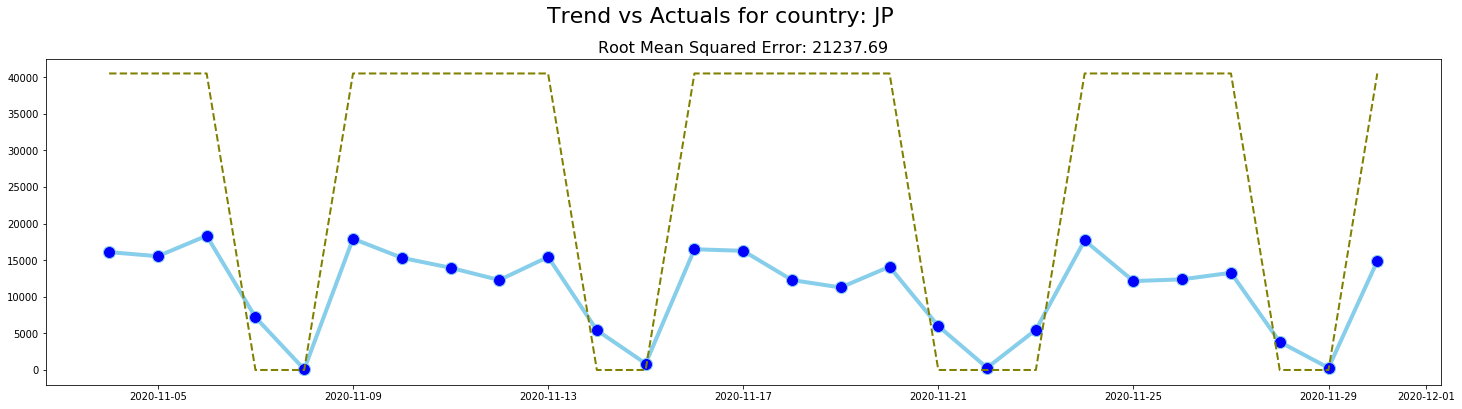

In [0]:
#Plot forecast and actual to visualize the fit with RMSE

Country = 'JP'

df = Daily_Sales\
  .join(Sales_Trend_B, on=["DT_BORD_REF","CAI_MARKET_FDM_SK","COMPANY_CODE","CUSTOMER_CODE","COUNTRY_ALPHA"], how='full')\
  .filter(month("DT_BORD_REF") == REF_DATE.month)\
  .filter(year("DT_BORD_REF") == REF_DATE.year)\
  .filter(dayofmonth("DT_BORD_REF") >= REF_DATE.day)\
  .filter(col("COUNTRY_ALPHA")==Country)\
  .groupBy("DT_BORD_REF").sum("QUANTITY","QTE_PREV")\
  .na.fill(0)\
  .select("DT_BORD_REF", col("sum(QUANTITY)").alias("QUANTITY"),col("sum(QTE_PREV)").alias("QTE_PREV"))\
  .sort("DT_BORD_REF")

rmse = df\
  .withColumn('difference', F.col('QUANTITY') - F.col('QTE_PREV'))\
  .withColumn('squared_difference', F.pow(F.col('difference'), F.lit(2).astype(IntegerType())))\
  .select(F.sqrt(F.avg(F.col('squared_difference'))).alias('rmse'))\
  .collect()[0][0]

df = df.toPandas()

plt.rcParams["figure.figsize"] = [25,6]

fig2 = plt.plot('DT_BORD_REF', 'QUANTITY', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
fig2 = plt.plot('DT_BORD_REF', 'QTE_PREV', data=df, marker='', color='olive', linewidth=2, linestyle='dashed')
fig2 = plt.suptitle('Trend vs Actuals for country: ' + Country, fontsize=22, x=0.5, y=1)
fig2 = plt.title('Root Mean Squared Error: '+str(round(rmse,2)), fontsize=16)

display()



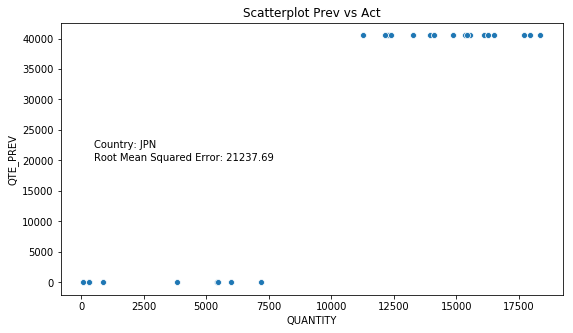

In [0]:
#Analysis of prediction Sales_Trend_B:

# display(df_pandas)
plt.rcParams["figure.figsize"] = [9,5]
fig = sns.scatterplot(data=df, x='QUANTITY', y='QTE_PREV')
fig.set_title('Scatterplot Prev vs Act')
fig.text(500, 40000, 'Country: '+ Country)
fig.text(500, 38000, 'Root Mean Squared Error: '+str(round(rmse,2)))
display(fig)